In [33]:
import cv2 as cv
import numpy as np
import mediapipe as mp # python 3.8 | 3.11
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math
from PIL import Image, ImageDraw

In [34]:
# regions of interest (roi)
forehead = [10,338,297,332,298,293,334,296,336,9,107,66,105,63,68,103,67,109,10]
left_cheek= [116,117,118,119,100,142,203,206,216,192,213,147,123,116]
right_cheek = [345,346,347,348,329,371,423,426,436,416,433,376,352,345]
face = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10]


DESIRED_HEIGHT = 600
DESIRED_WIDTH = 600

def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
      img = cv.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
      img = cv.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
      
    cv.imshow('output',img)
    cv.waitKey(0) 
    cv.destroyAllWindows()

In [35]:
def region_of_interest_segmentation(roi, info, img):
    imArray = np.asarray(img)
    
    polygon = []
    for i in range(len(roi)):
        idx_s = roi[i]
        start_point = (info[idx_s][3], info[idx_s][4])
        polygon.append(start_point)
    
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = np.array(maskIm)

    newImArray = np.zeros(img.shape, dtype='uint8')
    
    newImArray[:,:,0] = np.multiply(imArray[:,:,0], mask)
    newImArray[:,:,1] = np.multiply(imArray[:,:,1], mask)
    newImArray[:,:,2] = np.multiply(imArray[:,:,2], mask)

    return newImArray, mask


In [36]:

def segmentation(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces = 1, min_detection_confidence=0.5)

    results = face_mesh.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    landmarks = results.multi_face_landmarks[0]

    shape_a = image.shape[1] 
    shape_b = image.shape[0] 
    info = [] 

    for landmark in landmarks.landmark:
        x = landmark.x
        y = landmark.y
        z = landmark.z

        relative_x = int(shape_a * x)
        relative_y = int(shape_b * y)

        info.append([x,y,z,relative_x,relative_y])

    img1,_ = region_of_interest_segmentation(forehead, info, image)
    img2,_ = region_of_interest_segmentation(left_cheek, info, image)
    img3,_ = region_of_interest_segmentation(right_cheek, info, image)

    regions_interest = np.maximum(np.maximum(img1, img2), img3)
    
    return regions_interest


In [37]:
def segmentation2(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces = 1, min_detection_confidence=0.5)

    results = face_mesh.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    landmarks = results.multi_face_landmarks[0]

    shape_a = image.shape[1] 
    shape_b = image.shape[0] 
    info = [] 

    for landmark in landmarks.landmark:
        x = landmark.x
        y = landmark.y
        z = landmark.z

        relative_x = int(shape_a * x)
        relative_y = int(shape_b * y)

        info.append([x,y,z,relative_x,relative_y])

    img1,_ = region_of_interest_segmentation(face, info, image)

    regions_interest = img1
    
    return regions_interest

In [38]:
def colour_transfer_idt(i0, i1, bins=300, n_rot=10, relaxation=1):

    n_dims = i0.shape[1]
    
    d0 = i0.T
    d1 = i1.T
    
    for i in range(n_rot):
        r = sp.stats.special_ortho_group.rvs(n_dims).astype(np.float32)
        
        d0r = np.dot(r, d0)
        d1r = np.dot(r, d1)
        d_r = np.empty_like(d0)
        
        for j in range(n_dims):
            
            valid_d0r = d0r[j][~np.isnan(d0r[j])]
            valid_d1r = d1r[j][~np.isnan(d1r[j])]
            
            if len(valid_d0r) == 0 or len(valid_d1r) == 0:
                continue
            
            lo = min(valid_d0r.min(), valid_d1r.min())
            hi = max(valid_d0r.max(), valid_d1r.max())
            
            p0r, edges = np.histogram(valid_d0r, bins=bins, range=[lo, hi])
            p1r, _ = np.histogram(valid_d1r, bins=bins, range=[lo, hi])
                
            cp0r = p0r.cumsum().astype(np.float32)
            cp0r /= cp0r[-1]
            
            cp1r = p1r.cumsum().astype(np.float32)
            cp1r /= cp1r[-1]
            
            f = np.interp(cp0r, cp1r, edges[1:])
        
            d_r[j] = np.interp(d0r[j], edges[1:], f, left=lo, right=hi)
            
        d0 = relaxation * np.linalg.solve(r, (d_r - d0r)) + d0
    
    return d0.T

In [44]:
# google monk skin tone examples
path = "img/input.jpg"
img_input = cv.imread(path)

path = "img/target.jpg"
img_target = cv.imread(path)

width = int(img_input.shape[1] * 20 / 100)
height = int(img_input.shape[0] * 20 / 100)
dim = (width, height)

img_target = cv.resize(img_target, dim)
img_input = cv.resize(img_input, dim)

roi_input = cv.cvtColor(segmentation2(img_input), cv.COLOR_BGR2RGB)
roi_target = cv.cvtColor(segmentation2(img_target), cv.COLOR_BGR2RGB)

df_roi_ipt = pd.DataFrame(roi_input.reshape(-1, roi_input.shape[-1]), columns=['r', 'g', 'b'])
df_roi_tgt = pd.DataFrame(roi_target.reshape(-1, roi_target.shape[-1]), columns=['r', 'g', 'b'])

df_roi_ipt_nan = df_roi_ipt.mask((df_roi_ipt[['r', 'g', 'b']] == 0).all(axis=1))
df_roi_tgt_nan = df_roi_tgt.mask((df_roi_tgt[['r', 'g', 'b']] == 0).all(axis=1))

a_input = df_roi_ipt_nan.values
a_target = df_roi_tgt_nan.values

a_result = colour_transfer_idt(a_input, a_target, bins=300, n_rot=20, relaxation=1)

df_result = pd.DataFrame(a_result, columns=['r', 'g', 'b'])
img_output = a_result.reshape(roi_input.shape)

img_output = cv.convertScaleAbs(img_output)
#img_output= cv.cvtColor(img_output, cv.COLOR_RGB2BGR)

#resize_and_show(cv.cvtColor(roi_input, cv.COLOR_RGB2BGR))
#resize_and_show(img_output)
#cv.imwrite("img/o6.jpg", cv.cvtColor(img_output, cv.COLOR_RGB2BGR))

I0000 00:00:1716675059.356421 1297718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716675059.357771 1306563 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.6), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 17.0.6, DRM 3.57, 6.8.8-200.fc39.x86_64)
I0000 00:00:1716675059.396665 1297718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716675059.397728 1306571 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.6), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 17.0.6, DRM 3.57, 6.8.8-200.fc39.x86_64)


True

In [64]:

# google monk skin tone examples
path = "img/e1.jpg"
img2 = cv.imread(path)

path = "img/target.jpg"
img1 = cv.imread(path)

path = "img/input.jpg"
img3 = cv.imread(path)

width = int(img3.shape[1] * 20 / 100)
height = int(img3.shape[0] * 20 / 100)
dim = (width, height)

img1 = cv.resize(img1, dim)
img2 = cv.resize(img2, dim)
img3 = cv.resize(img3, dim)


cv.imwrite("img/e1.jpg", img2)
cv.imwrite("img/e2.jpg", img3)
cv.imwrite("img/e33.jpg", img1)

o1 = segmentation(img1)
o2 = segmentation2(img1)

o3 = segmentation(img2)
o4 = segmentation2(img2)

o5 = segmentation(img3)
o6 = segmentation2(img3)

cv.imwrite("img/o51.jpg", o5)
cv.imwrite("img/o61.jpg", o6)

I0000 00:00:1716678703.909799 1297718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716678703.911259 1317684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.6), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 17.0.6, DRM 3.57, 6.8.8-200.fc39.x86_64)
I0000 00:00:1716678703.955963 1297718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716678703.957381 1317692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.6), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 17.0.6, DRM 3.57, 6.8.8-200.fc39.x86_64)
I0000 00:00:1716678703.998403 1297718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716678703.999541 1317705 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.6), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 17.0.6, DRM 3.57, 6.8.8-200.fc39.x86_64)
I0000 00:00:1716678704.052112 1297718 gl_context_egl.cc:85] Successfully ini

True

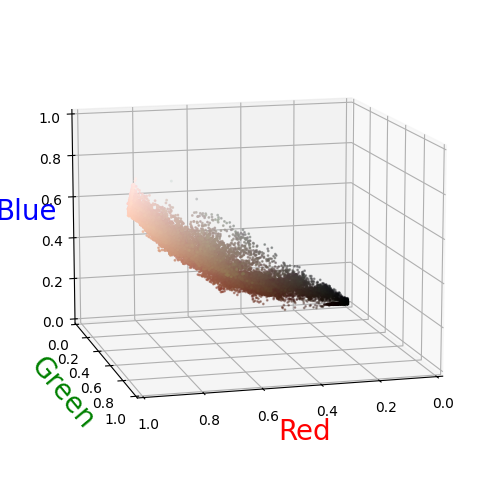

In [76]:
from matplotlib.colors import ListedColormap



def image_to_rgb_array(image_path):
    image = Image.open(image_path)
    image = image.convert('RGB')  # Garantir que a imagem está em RGB
    data = np.array(image)
    return data.reshape((-1, 3)) / 255.0  # Normalizar os valores de cor para o intervalo [0, 1]

def create_rgb_colormap(rgb_data):
    # Normaliza os dados para o intervalo [0, 1]
    rgb_data_norm = rgb_data / 255.0
    # Cria a colormap utilizando os dados normalizados
    cmap = ListedColormap(rgb_data_norm)
    return cmap

# Caminho para a sua imagem
image_path = 'paper/o6.jpg'

# Converter imagem para array de cores RGB
rgb_target = image_to_rgb_array(image_path)

fig = plt.figure(figsize=(10, 5))

# Subplot 1 - Target
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(rgb_target[:, 0], rgb_target[:, 1], rgb_target[:, 2], c=rgb_target, s=1)
ax1.set_xlabel('Red', fontsize=20)
ax1.set_ylabel('Green',  fontsize=20)
ax1.set_zlabel('Blue',  fontsize=20)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_zlim([0, 1])
ax1.set_xlabel('Red', color='red')
ax1.set_ylabel('Green', color='green')
ax1.set_zlabel('Blue', color='blue')


ax1.view_init(elev=12, azim=75) #10, 70
    
# Ajustar layout e mostrar gráfico
plt.tight_layout()
plt.show()